In [23]:
import pandas as pd

In [24]:
trayectos = pd.read_csv("trayectos.csv", index_col=0)
trayectos['Hora_salida'] = pd.to_datetime(trayectos['Hora_salida'], format='%H:%M')
trayectos['Hora_llegada'] = pd.to_datetime(trayectos['Hora_llegada'], format='%H:%M')

In [63]:
prueba = trayectos[trayectos["Nombre_rutina"].str.contains("prueba")]

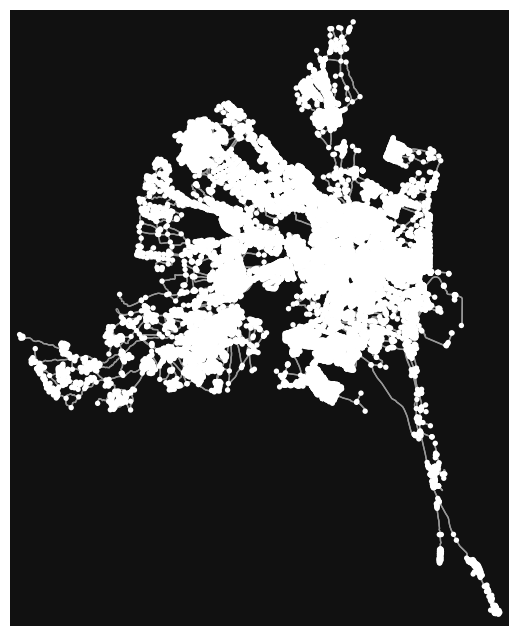

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [64]:
import osmnx as ox
import networkx as nx

lugares = ["Valencia, Spain", "Catarroja, Spain", "Torrent, Spain", "Alboraya, Spain", "Moncada, Spain", "Manises, Spain",
          "Tavernes Blanques, Spain", "Meliana, Spain", "Burjasot, Spain", "Paterna, Spain", "Mislata, Spain",
          "Alaquàs, Spain", "Xirivella, Spain", "Paiporta, Spain", "Alfafar, Spain", "Benetúser, Spain", "Sedaví, Spain",
          "Aldaya, Spain", "Quart de Poblet, Spain"]

# Crear un diccionario para almacenar los grafos de cada lugar
grafos_por_lugar = {}

# Obtener el grafo de carreteras para cada lugar y almacenarlo en el diccionario
for lugar in lugares:
    grafo_lugar = ox.graph_from_place(lugar, network_type="drive")
    grafos_por_lugar[lugar] = grafo_lugar

grafo = nx.compose_all(grafos_por_lugar.values())

ox.plot_graph(grafo)

In [65]:
trayectos

,Nombre_rutina,Id_usuario,Lugar_salida,Lugar_llegada,Hora_salida,Hora_llegada,Motivo,Dia,Disponibilidad_coche,Viejo_trayecto
0,[Indefinido]_lunes,111831,"39.50122800718866, -0.41927966292614793","39.44984907483212, -0.3923317810900036",1900-01-01 13:50:00,1900-01-01 14:12:00,Otro,Lunes,Pasajero,Tren
1,Estudios_universidad_miercoles,982437,"39.47448582694143, -0.36973136061629475","39.52827350270283, -0.3752537306405829",1900-01-01 07:00:00,1900-01-01 07:24:00,Estudios,Miercoles,Coche y pasajero,Tren
2,Deporte_futbol_miercoles,220786,"39.487288123748414, -0.3832181679770428","39.46320872584864, -0.378861657627463",1900-01-01 14:15:00,1900-01-01 14:25:00,Deporte,Miercoles,Pasajero,Bus
3,Deporte_tenis_viernes,362659,"39.464666255889306, -0.378869876395067","39.48122685723318, -0.357178565188734",1900-01-01 15:25:00,1900-01-01 15:35:00,Deporte,Viernes,Coche y pasajero,Coche
4,Ocio_viernes,693935,"39.41972386577771, -0.3892850451039514","39.45630189278762, -0.3795688513211948",1900-01-01 07:50:00,1900-01-01 08:09:00,Ocio,Viernes,Coche,Tren
...,...,...,...,...,...,...,...,...,...,...
69995,prueba_6,156939,"39.478350, -0.347192","39.404948, -0.406213",1900-01-01 07:25:00,1900-01-01 08:00:00,Trabajo,Lunes,Coche y pasajero,Coche
69996,prueba_7,156939,"39.478350, -0.347192","39.404948, -0.406213",1900-01-01 07:25:00,1900-01-01 07:50:00,Trabajo,Lunes,Coche y pasajero,Coche
69997,prueba_8,156939,"39.478350, -0.347192","39.404948, -0.406213",1900-01-01 07:25:00,1900-01-01 07:55:00,Trabajo,Lunes,Coche y pasajero,Coche
69998,prueba_9,156939,"39.478350, -0.347192","39.404948, -0.406213",1900-01-01 07:25:00,1900-01-01 07:55:00,Trabajo,Lunes,Coche,Coche


In [91]:
from datetime import timedelta
import geopy.distance

def match(df, fila):
    #seleccionar las rutas que sean del mismo día
    dia = df.at[fila, 'Dia']
    match_dia = df[df['Dia'] == dia]
    
    #si la ruta es "Pasajero", descarar las rutas que también sean "Pasajero"
    coche = df.at[fila, 'Disponibilidad_coche']
    if coche == "Pasajero":
        match_dia = match_dia[~(match_dia['Disponibilidad_coche'] == "Pasajero")]
      
    #seleccionar las rutas que difieran menos de 45min de salir o llegar
    tolerance = timedelta(minutes=45)
    hora_llegada_fila = df.loc[fila, 'Hora_llegada']
    hora_salida_fila = df.loc[fila, 'Hora_salida']
    match_dia = match_dia[abs(hora_llegada_fila - match_dia['Hora_llegada']) <= tolerance]
    match_dia = match_dia[abs(hora_salida_fila - match_dia['Hora_salida']) <= tolerance]

    
    #MIRAR SI SE PUEDEN CALCULAR LAS DISTANCIAS CON EL grafo (LO HE INTENTADO) y no con geopy.distance
    #calcular las distancias de salida y de llegada con el resto de filas
    destino_fila = df.at[fila, 'Lugar_llegada']
    destino_fila = tuple(map(float, destino_fila.split(', ')))
    salida_fila = df.at[fila, 'Lugar_salida']
    salida_fila = tuple(map(float, salida_fila.split(', ')))
    
    for index, row in match_dia.iterrows():
        destino = (float(row['Lugar_llegada'].split(', ')[0]), float(row['Lugar_llegada'].split(', ')[1]))
        salida = (float(row['Lugar_salida'].split(', ')[0]), float(row['Lugar_salida'].split(', ')[1]))
        distancia_llegada = geopy.distance.geodesic(destino_fila, destino).km
        distancia_salida = geopy.distance.geodesic(salida_fila, salida).km
        match_dia.at[index, 'Distancia_llegada'] = distancia_llegada
        match_dia.at[index, 'Distancia_salida'] = distancia_salida
    return match_dia


fila_de_prueba = 4567
filas_coincidentes = match(trayectos, fila_de_prueba)

In [92]:
filas_coincidentes[(filas_coincidentes.Distancia_llegada<1) & (filas_coincidentes.Distancia_salida<1)]

,Nombre_rutina,Id_usuario,Lugar_salida,Lugar_llegada,Hora_salida,Hora_llegada,Motivo,Dia,Disponibilidad_coche,Viejo_trayecto,Distancia_llegada,Distancia_salida
4567,Deporte_padel_sabado,980305,"39.46514859445717, -0.3730444540408307","39.42364316010829, -0.39850468836618413",1900-01-01 08:00:00,1900-01-01 08:22:00,Deporte,Sabado,Coche,Coche,0.000000,0.000000
11390,Ocio_sabado,856555,"39.4566060868129, -0.37633033478903244","39.425024769433676, -0.39073970217350484",1900-01-01 08:15:00,1900-01-01 08:31:00,Ocio,Sabado,Coche y pasajero,Metro,0.685986,0.989687
40018,Deporte_futbol_sabado,737722,"39.461918427607436, -0.37393938687160766","39.41911254905993, -0.38985284722000346",1900-01-01 07:45:00,1900-01-01 08:04:00,Deporte,Sabado,Coche,Coche,0.898920,0.366804
